In [ ]:
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
training_data_dir = "CovidDataset/Train"
validation_data_dir = "CovidDataset/Test"


In [ ]:
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS =25
BATCH_SIZE =2
TEST_SIZE = 2
learning = 0.00001
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [ ]:
from keras.applications.vgg16 import VGG16
%matplotlib inline

base_model=VGG16(weights='imagenet',include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=learning, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='categorical_crossentropy',metrics=['accuracy'])

import warnings
warnings.filterwarnings("ignore")

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [ ]:
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)

Found 224 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Training
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE, 
    verbose=1)


Epoch 1/25
112/112 [==============================] - 113s 1s/step - loss: 0.3187 - accuracy: 0.8750 - val_loss: 0.3751 - val_accuracy: 0.9833
Epoch 2/25
112/112 [==============================] - 107s 952ms/step - loss: 0.0305 - accuracy: 0.9911 - val_loss: 2.5943 - val_accuracy: 0.9500
Epoch 3/25
112/112 [==============================] - 106s 943ms/step - loss: 0.0412 - accuracy: 0.9821 - val_loss: 0.1764 - val_accuracy: 1.0000
Epoch 4/25
112/112 [==============================] - 107s 952ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1026 - val_accuracy: 1.0000
Epoch 5/25
112/112 [==============================] - 107s 954ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4480 - val_accuracy: 0.9833
Epoch 6/25
112/112 [==============================] - 106s 948ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0398 - val_accuracy: 1.0000
Epoch 7/25
112/112 [==============================] - 106s 947ms/step - loss: 2.2222e-04 - accuracy: 1.0000 - val_loss: 0.1766 

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred=model.predict(x=validation_generator,verbose=0)
np.round(y_pred)
cm=confusion_matrix(y_true=validation_generator.classes,y_pred=np.argmax(y_pred,axis=-1))
print(cm)

[[28  2]
 [ 0 30]]


Confusion matrix, without normalization
[[28  2]
 [ 0 30]]


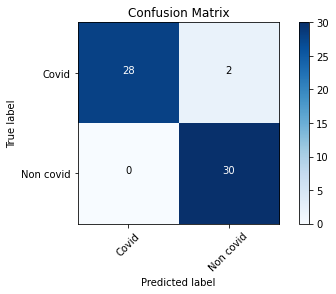

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cm_plot_labels = ['Covid','Non covid']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

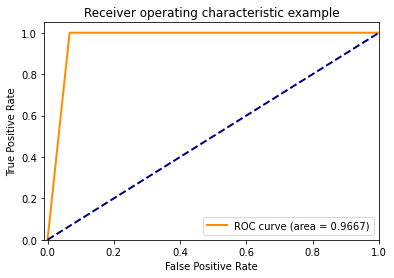

In [ ]:
#roc curves
from sklearn.metrics import classification_report,roc_curve, auc
filenames = validation_generator.filenames
nb_samples = len(filenames)
Y_pred = model.predict_generator(validation_generator,(nb_samples//BATCH_SIZE))
y_pred = np.argmax(Y_pred, axis=1)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
   fpr[i], tpr[i], _ = roc_curve(validation_generator.classes, y_pred)
   roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
       lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


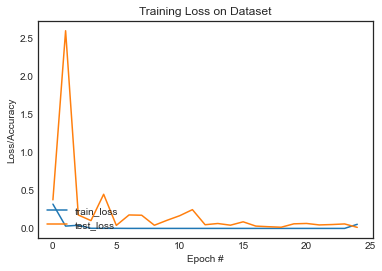

In [ ]:
from livelossplot import PlotLossesKeras
N=EPOCHS

plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

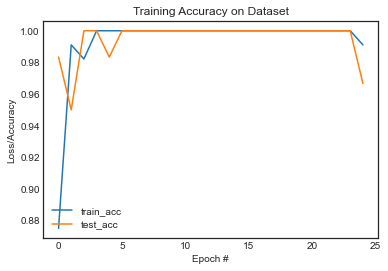

In [ ]:
plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")